In [257]:
import pandas as pd
import numpy as np
import random
import pickle
import os
import re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from itertools import combinations 
from sklearn.manifold import TSNE
from bokeh.plotting import figure, show, output_notebook, save
from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource

from sklearn import preprocessing
from collections import OrderedDict
import sys
from scipy import spatial


In [258]:
def back_to_list(df, col):
    """Convert columns in df back to lists from strings (this happens when saving to csv)
    """
    
    df[col] = [s.strip("'[") for s in df[col]]
    df[col] = [s.strip("]'") for s in df[col]]
    df[col] = [s.split("', '") for s in df[col]]
    
    return df[col]

In [264]:
# Load education and occupation details

jobs_df = pd.read_csv('/Users/amanda/Documents/Projects/insight/data/processed/jobbank-fields.csv')
details_df = pd.read_csv('/Users/amanda/Documents/Projects/insight/data/processed/jobbank-details.csv')
job_name_df = pd.read_csv('/Users/amanda/Documents/Projects/insight/data/processed/education-to-job.csv')


In [265]:
details_df

,link,job-title,intro,job-description,requirements,skills
0,/marketreport/summary-occupation/7859/ca,Locomotive Engineer - Railway in Canada,Find key facts and figures about working as a ...,Railway locomotive engineers operate railway l...,['College or apprenticeship'],"['Operate locomotives to switch, couple and un..."
1,/marketreport/summary-occupation/18193/ca,Optometrist in Canada,Find key facts and figures about working as an...,Optometrists examine eyes to assess and diagno...,['University'],"[""Examine patients' eyes, conduct tests and us..."
2,/marketreport/summary-occupation/2733/ca,Forester in Canada,Find key facts and figures about working as a ...,"Forestry professionals conduct research, devel...",['University'],"['Plan and direct road building, wildlife mana..."
3,/marketreport/summary-occupation/24789/ca,Administrative Assistant in Canada,Find key facts and figures about working as an...,Administrative assistants perform a variety of...,['College or apprenticeship'],"['Arrange and co-ordinate seminars, conference..."
4,/marketreport/summary-occupation/14598/ca,Investment Manager - Financial Brokerage in Ca...,Find key facts and figures about working as an...,"Insurance, real estate and financial brokerage...",['University'],['Establish and implement policies and procedu...
5,/marketreport/summary-occupation/251/ca,Human Resources Supervisor in Canada,Find key facts and figures about working as a ...,"Human resources professionals develop, impleme...",['University'],"['Plan, develop, implement and evaluate human ..."
6,/marketreport/summary-occupation/3954/ca,Systems Testing Technician in Canada,Find key facts and figures about working as a ...,Information systems testing technicians execut...,['College or apprenticeship'],['Develop and document software testing plans'...
7,/marketreport/summary-occupation/17862/ca,Physical Metallurgical Engineer in Canada,Find key facts and figures about working as a ...,Metallurgical and materials engineers conduct ...,['University'],['Conduct studies and develop processes and ma...
8,/marketreport/summary-occupation/12462/ca,Administrative Officer in Canada,Find key facts and figures about working as an...,Administrative officers oversee and implement ...,['College or apprenticeship'],"['Review, evaluate and implement new administr..."
9,/marketreport/summary-occupation/22376/ca,Civil Engineer in Canada,Find key facts and figures about working as a ...,"Civil engineers plan, design, develop and mana...",['University'],['Develop construction specifications and proc...


In [266]:
jobs_df['description'].str.split('found under ')
edu_categories = [s.split('found under ')[1] for s in jobs_df['description']]
edu_categories = [s.strip('.') for s in edu_categories]
jobs_df['education-groups'] = edu_categories

jobs_df['top-jobs'] = back_to_list(jobs_df, 'top-jobs')
jobs_df['top-job-links'] = back_to_list(jobs_df, 'top-job-links')
jobs_df['job-percent'] = back_to_list(jobs_df, 'job-percent')

education_df = jobs_df[['degree','education-groups','top-jobs','job-percent']].drop_duplicates(subset =['education-groups','degree']) 

In [267]:
details_df['requirements'] = back_to_list(details_df, 'requirements')
details_df['skills'] = back_to_list(details_df, 'skills')

In [268]:
#jobs_df['description'] = jobs_df['description'].str.strip('in Canada')
details_df['job-title'] = details_df['job-title'].str.rstrip('in Canada')

details_df

,link,job-title,intro,job-description,requirements,skills
0,/marketreport/summary-occupation/7859/ca,Locomotive Engineer - Railway,Find key facts and figures about working as a ...,Railway locomotive engineers operate railway l...,[College or apprenticeship],"[Operate locomotives to switch, couple and unc..."
1,/marketreport/summary-occupation/18193/ca,Optometrist,Find key facts and figures about working as an...,Optometrists examine eyes to assess and diagno...,[University],"[""Examine patients' eyes, conduct tests and us..."
2,/marketreport/summary-occupation/2733/ca,Forester,Find key facts and figures about working as a ...,"Forestry professionals conduct research, devel...",[University],"[Plan and direct road building, wildlife manag..."
3,/marketreport/summary-occupation/24789/ca,Administrative Assistant,Find key facts and figures about working as an...,Administrative assistants perform a variety of...,[College or apprenticeship],"[Arrange and co-ordinate seminars, conferences..."
4,/marketreport/summary-occupation/14598/ca,Investment Manager - Financial Brokerage,Find key facts and figures about working as an...,"Insurance, real estate and financial brokerage...",[University],[Establish and implement policies and procedur...
5,/marketreport/summary-occupation/251/ca,Human Resources Supervisor,Find key facts and figures about working as a ...,"Human resources professionals develop, impleme...",[University],"[Plan, develop, implement and evaluate human r..."
6,/marketreport/summary-occupation/3954/ca,Systems Testing Technic,Find key facts and figures about working as a ...,Information systems testing technicians execut...,[College or apprenticeship],"[Develop and document software testing plans, ..."
7,/marketreport/summary-occupation/17862/ca,Physical Metallurgical Engineer,Find key facts and figures about working as a ...,Metallurgical and materials engineers conduct ...,[University],[Conduct studies and develop processes and mac...
8,/marketreport/summary-occupation/12462/ca,Administrative Officer,Find key facts and figures about working as an...,Administrative officers oversee and implement ...,[College or apprenticeship],"[Review, evaluate and implement new administra..."
9,/marketreport/summary-occupation/22376/ca,Civil Engineer,Find key facts and figures about working as a ...,"Civil engineers plan, design, develop and mana...",[University],[Develop construction specifications and proce...


# Preprocessing text columns

In [269]:
def preprocess(text):
    """ preprocess text: remove special characters, remove digits, tokenize,
    lowercase, remove stopwords, lemmatize
    """
    # preparing for text preprocessing: tokenizer, stopwords, and lemmatizer
    tokenizer = RegexpTokenizer(r'\w+')
    stopwords_en = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    
    text = re.sub('[^a-zA-Z]', ' ', text )
    text = re.sub(r'\s+', ' ', text)
    tokens = tokenizer.tokenize(text)
    tokens = [token.lower() for token in tokens if len(token)>1]
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stopwords_en]
    return ' '.join(tokens)

In [270]:
# preprocess job title and description
for col in ['job-title', 'job-description']:
    details_df[col] = details_df[col].str.strip('in Canada')
    details_df[col] = details_df[col].astype(str)
    details_df[col+'-processed'] = details_df[col].apply(preprocess)

# have a column for both title and descritpion
cols = ['job-title-processed', 'job-description-processed']
details_df['title-and-desc'] = details_df[cols].apply(lambda x: ' '.join(x), axis=1)


In [271]:
def plot_common_words(df, column, n):
    """plot n most common words in a column of a df"""
    fdist = Counter(' '.join(row for row in df[column]).split()).most_common(n) # freq distribution of n most common words
    word = [i[0] for i in fdist]
    count = [i[1] for i in fdist]
    word_pos = [i for i, _ in enumerate(word)]
    
    plt.figure(figsize=(8, 6))
    plt.barh(word_pos, count)
    plt.yticks(word_pos, word)
    plt.ylabel('word')
    plt.xlabel('count')
    plt.title('Frequency of'+' '+str(n)+' '+'most common words in {}'.format(column))
    plt.gca().invert_yaxis() # invert y axis to descending order
    plt.show()

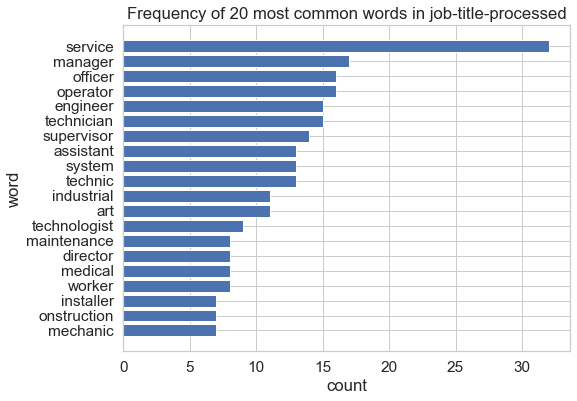

In [272]:
# plot most common words in job titles
sns.set(style='whitegrid', font_scale=1.4)
plot_common_words(details_df, 'job-title-processed', 20)

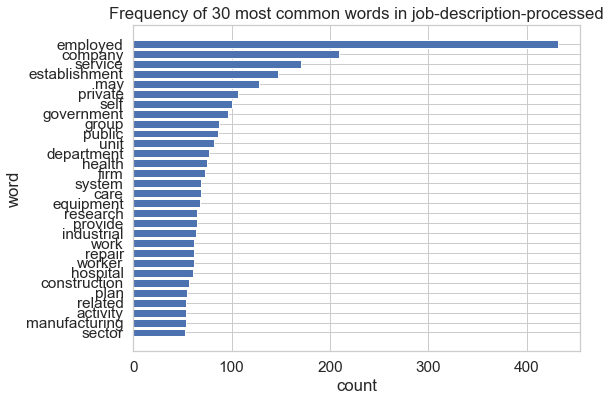

In [273]:
plot_common_words(details_df, 'job-description-processed', 30)

In [274]:
# vectorize job description - for work_exp df
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=5000)
job_description_vec = vectorizer.fit_transform(details_df['job-description-processed'])

In [275]:
def multiple_nmf(kmin, kmax, vec_text):
    """run multiple nmf models with a chosen range of number of components,
    return a list XXXXX
    
    kmin -- minimum number of topics
    kmax -- maximum number of topics
    vec_text -- vectorized text
    """
    topic_models = []
    for k in range(kmin, kmax+1):
        print("Applying NMF for k=%d ..." % k)
        nmf = NMF(n_components=k,
                  init="nndsvd",
                  alpha=0.1,
                  random_state=42) 
        W = nmf.fit_transform(vec_text)
        H = nmf.components_    
        topic_models.append((k, nmf, W, H))
    
    return topic_models

In [276]:
topic_models = multiple_nmf(10, 20, job_description_vec)

Applying NMF for k=10 ...
Applying NMF for k=11 ...
Applying NMF for k=12 ...
Applying NMF for k=13 ...
Applying NMF for k=14 ...
Applying NMF for k=15 ...
Applying NMF for k=16 ...
Applying NMF for k=17 ...
Applying NMF for k=18 ...
Applying NMF for k=19 ...
Applying NMF for k=20 ...


In [277]:
# convert job_description_processed to a list of lists for word2vec model
job_desc_train = details_df['job-description-processed'].apply(lambda x: x.split(' ')).tolist()

# train word2vec model
word2vec_model = Word2Vec(job_desc_train,
                          size=200,
                          window=8,
                          min_count=5,
                          workers=4)
word2vec_model.train(job_desc_train, total_examples=len(job_desc_train), epochs=10)

(70934, 120580)

In [278]:
# have a look at the word2vec results
word2vec_model.wv.most_similar(positive='clean')

[('perform', 0.9997376203536987),
 ('farm', 0.9997319579124451),
 ('variety', 0.9997295141220093),
 ('various', 0.9997166395187378),
 ('order', 0.9997118711471558),
 ('body', 0.9997106790542603),
 ('specialized', 0.9996958374977112),
 ('part', 0.9996894001960754),
 ('specialist', 0.9996867179870605),
 ('duty', 0.9996746778488159)]

In [279]:
def get_top_terms(vectorizer, H, n_top_terms):
    """get terms most important for each of the topics of an nmf model
    return a dictionary with topic number as key and a list of top terms as values
    
    vectorizer -- vectorizer for text
    H -- topic term matrix from nmf model
    n_top_terms -- number of top words to choose
    """
    terms = vectorizer.get_feature_names()
    
    top_terms_dict = {};
    # for each topic, get the largest weights, and save the corresponding words into the dictionary
    num_topics = H.shape[0]
    for i in range(num_topics):
        ids = H[i].argsort()[-n_top_terms:] 
        # word_ids is ordered such that largest weight is the last item, reverse it to have it as first item
        top_terms_dict['Topic '+'{:01d}'.format(i+1)] = [terms[id] for id in reversed(ids)]
        
    return top_terms_dict

def compute_coherence(word2vec_model, top_terms_dict):
    """compute coherence score, ie, mean pairwise similarity of top terms
    
    word2vec_model -- word2vec model trained on words in dataset
    top_term_dict -- top words of each topic (output of get_top_terms() function)
    """
    overall_coherence = 0.0
    num_topics = len(top_terms_dict)
    for i in range(num_topics):
        pair_scores = []
        # compute similarity score for each pair of top words in each topic
        for pair in combinations(top_terms_dict['Topic '+'{:01d}'.format(i+1)], 2):
            pair_scores.append(word2vec_model.wv.similarity(pair[0], pair[1]))
        
        topic_score = sum(pair_scores)/len(pair_scores)
        overall_coherence += topic_score
    
    # get mean score across topics
    return overall_coherence/num_topics

def compare_coherence(topic_models, vectorizer, n_top_terms, word2vec_model):
    """get topic coherence for multiple nmf models
    
    topic_models -- output of multiple_nmf() function
    """
    coherence_dict = {}
    for i in range(len(topic_models)):
        top_terms_dict = get_top_terms(vectorizer, topic_models[i][3], n_top_terms) # 4th element of each list in topic_models: H     
        
        k = topic_models[i][0] # first element of each list in topic models: k
        coherence = compute_coherence(word2vec_model, top_terms_dict)
        print("K=%02d: Coherence=%.4f" % (k, coherence))
        coherence_dict[k] = coherence
        
    return coherence_dict

In [280]:
# get top words for each of 20 topics
best_k = 20
top_words = pd.DataFrame(get_top_terms(vectorizer, topic_models[best_k-10][3], 15))
W = topic_models[best_k-10][2]

In [281]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [282]:
# have a look at top words in each of the 20 topics
top_words

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20
0,engineering,care,officer,retail,information,construction,television,electrical,design,manager,food,financial,medical,metal,school,library,sport,practice,worker,insurance
1,chemical,health,government,wholesale,software,building,production,power,firm,organize,restaurant,investment,laboratory,product,secondary,museum,fitness,disorder,railway,agent
2,consulting,nursing,program,sale,technology,contractor,radio,equipment,advertising,direct,beverage,accounting,technologist,machine,teacher,archive,recreational,clinic,co,company
3,engineer,home,federal,establishment,system,structure,motion,system,conceptualize,evaluate,hotel,trust,hospital,aircraft,elementary,gallery,recreation,work,ordinate,real
4,company,nurse,provincial,store,sector,install,picture,repair,designer,control,prepare,credit,treatment,shop,vocational,art,program,diagnose,supervise,estate
5,research,hospital,resource,service,throughout,employed,theatre,electronic,self,plan,serve,bank,clinic,repair,college,user,facility,animal,activity,branch
6,technologist,patient,organization,sell,computer,wall,video,transmission,architectural,department,establishment,company,included,sheet,subject,public,centre,treat,equipment,broker
7,technical,provide,research,business,public,concrete,recording,test,employed,operation,service,union,administrative,tool,teach,material,athletic,private,group,determine
8,independently,service,policy,good,private,self,company,distribution,landscape,senior,cafeteria,representative,office,manufacturing,academic,collection,organization,patient,gas,office
9,government,registered,conduct,technical,telecommunication,may,dance,generation,may,establishment,hospital,transaction,disease,material,university,artifact,community,prevent,contractor,head


In [283]:
# have a df for document topic matrix, merge with df_work
W = topic_models[best_k-10][2]

topic_weights = pd.DataFrame(W, columns=['Topic '+'{:01d}'.format(i+1) for i in range(best_k)])
topic_weights1 = pd.DataFrame.copy(topic_weights)
# normalize topic weights such that they sum to 1 for each ducoment/job description
topic_weights1 = topic_weights1.div(topic_weights1.sum(axis=1), axis=0)

# find top 3 topics for each document/job description
topic_weights1['highest_topic1'] = topic_weights.idxmax(axis=1)
topic_weights1['highest_topic2'] = topic_weights.T.apply(lambda x: x.nlargest(2).idxmin())
topic_weights1['highest_topic3'] = topic_weights.T.apply(lambda x: x.nlargest(3).idxmin())

df_work_train = pd.concat([details_df, topic_weights1], axis=1, sort=False)

In [284]:
df_work_train.head()

,link,job-title,intro,job-description,requirements,skills,job-title-processed,job-description-processed,title-and-desc,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,highest_topic1,highest_topic2,highest_topic3
0,/marketreport/summary-occupation/7859/ca,Locomotive Engineer - Railway,Find key facts and figures about working as a ...,Railway locomotive engineers operate railway l...,[College or apprenticeship],"[Operate locomotives to switch, couple and unc...",locomotive engineer railway,railway locomotive engineer operate railway lo...,locomotive engineer railway railway locomotive...,0.048592,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.024994,0.019879,0.000000,0.000000,0.000000,0.000000,0.000000,0.019498,0.0,0.000000,0.887037,0.000000,Topic 19,Topic 1,Topic 9
1,/marketreport/summary-occupation/18193/ca,Optometrist,Find key facts and figures about working as an...,Optometrists examine eyes to assess and diagno...,[University],"[""Examine patients' eyes, conduct tests and us...",optometrist,optometrist examine eye ass diagnose ocular di...,optometrist optometrist examine eye ass diagno...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.990651,0.000000,0.009349,Topic 18,Topic 20,Topic 1
2,/marketreport/summary-occupation/2733/ca,Forester,Find key facts and figures about working as a ...,"Forestry professionals conduct research, devel...",[University],"[Plan and direct road building, wildlife manag...",forester,forestry professional conduct research develop...,forester forestry professional conduct researc...,0.198660,0.0,0.670389,0.0,0.000000,0.029736,0.008932,0.0,0.006685,0.069755,0.015844,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,Topic 3,Topic 1,Topic 10
3,/marketreport/summary-occupation/24789/ca,Administrative Assistant,Find key facts and figures about working as an...,Administrative assistants perform a variety of...,[College or apprenticeship],"[Arrange and co-ordinate seminars, conferences...",administrative assistant,administrative assistant perform variety admin...,administrative assistant administrative assist...,0.000000,0.0,0.279559,0.0,0.199263,0.000000,0.076475,0.0,0.000000,0.003526,0.000000,0.032189,0.241961,0.011455,0.026436,0.129137,0.0,0.000000,0.000000,0.000000,Topic 3,Topic 13,Topic 5
4,/marketreport/summary-occupation/14598/ca,Investment Manager - Financial Brokerage,Find key facts and figures about working as an...,"Insurance, real estate and financial brokerage...",[University],[Establish and implement policies and procedur...,investment manager financial brokerage,insurance real estate financial brokerage mana...,investment manager financial brokerage insuran...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.244191,0.000000,0.205023,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.550786,Topic 20,Topic 10,Topic 12


In [318]:
job_name_df['top-job-links'].fillna('', inplace=True)

In [319]:
link_list = [i.split(';')[0] for i in job_name_df['top-job-links']]

job_name_df['top-job-links'] = link_list

In [364]:
def uniqueness(df1,df2,group):

    group_jobs = df1.where(df1['education-groups']==group).dropna().drop_duplicates(['top-jobs'])
    
    is_job = df2[df2.link.isin(group_jobs['top-job-links'])]
    
    not_job = df2[~df2.link.isin(group_jobs['top-job-links'].values)]
    
    job_mean = (is_job.iloc[:,-23:-3]).mean(axis = 0, skipna = True)
    
    results = []
    similarity = []
    for i in range(len(not_job)):
        b = not_job.iloc[i,-23:-3]
        c_sim = 1 - spatial.distance.cosine(job_mean, b)
        similarity.append(c_sim)

    not_job['similarity'] = similarity
    
    sorted_df = not_job.sort_values(by=['similarity'],ascending=False)
    
    results = sorted_df['job-title'][0:10]
    
    return list(results)
    

In [362]:
results = uniqueness(job_name_df,df_work_train,'Sociology')

/Users/amanda/.local/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [363]:
results

59               Distance Education Program Co-ordinator
48                               Educational Sociologist
187    Special Education Technician - Persons With Di...
246                                  Academic Counsellor
253          Naval Electronics Technician - Armed Forces
15                      Elementary School Teacher's Aide
94         Admissions Director - Post-secondary Educatio
154                         Foreign Broadcast Translator
66                           Occupational Therapist (OT)
171    Superintendent Of Education Programs In Public...
Name: job-title, dtype: object

In [343]:
len(df_work_train)

327

In [290]:
job_name_df.to_csv('/Users/amanda/Documents/Projects/insight/data/processed/model-1.csv', index=False)
df_work_train.to_csv('/Users/amanda/Documents/Projects/insight/data/processed/model-2.csv', index=False)





